#Labwork 6

In [4]:
import numpy as np
from numba import cuda, jit, prange
import cv2
from time import time
import matplotlib.pyplot as plt

In [12]:
# Load image
img = plt.imread('/content/wolf.jpg')
img2 = plt.imread('/content/wolf2.jpg')

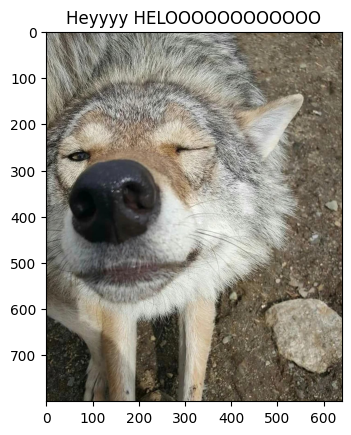

In [13]:
# Display the original image
plt.figure()
plt.imshow(img)
plt.title('Heyyyy HELOOOOOOOOOOOO')
plt.show()

In [ ]:
def rgb2gray(image):
    return np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])

In [7]:
@cuda.jit
def binarize_image_gpu(input_image, output_image, threshold):
    x, y = cuda.grid(2)
    if x < input_image.shape[1] and y < input_image.shape[0]:
        output_image[y, x] = 1 if input_image[y, x] >= threshold else 0

In [8]:
@cuda.jit
def adjust_brightness_gpu(input_image, output_image, factor):
    x, y = cuda.grid(2)
    if x < input_image.shape[1] and y < input_image.shape[0]:
        output_image[y, x] = min(max(int(input_image[y, x] * factor), 0), 255)

In [9]:
@cuda.jit
def blend_images_gpu(image1, image2, output_image, alpha):
    x, y = cuda.grid(2)
    if x < image1.shape[1] and y < image1.shape[0]:
        output_image[y, x] = min(max(int(image1[y, x] * alpha + image2[y, x] * (1 - alpha)), 0), 255)

In [14]:
# Parameters
threshold = 128
brightness_factor = 1.5  # Increase brightness
alpha = 0.5  # Blending coefficient

In [15]:
# Convert to grayscale
gray_image1 = rgb2gray(img)
gray_image2 = rgb2gray(img2)

In [16]:
# Prepare output images
binary_image = np.zeros_like(gray_image1, dtype=np.uint8)
bright_image = np.zeros_like(gray_image1, dtype=np.uint8)
blended_image = np.zeros_like(gray_image1, dtype=np.uint8)

In [17]:
# Define grid and block sizes
threads_per_block = (16, 16)
blocks_per_grid = (gray_image1.shape[1] // threads_per_block[0] + 1,
                   gray_image1.shape[0] // threads_per_block[1] + 1)


array([[1, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
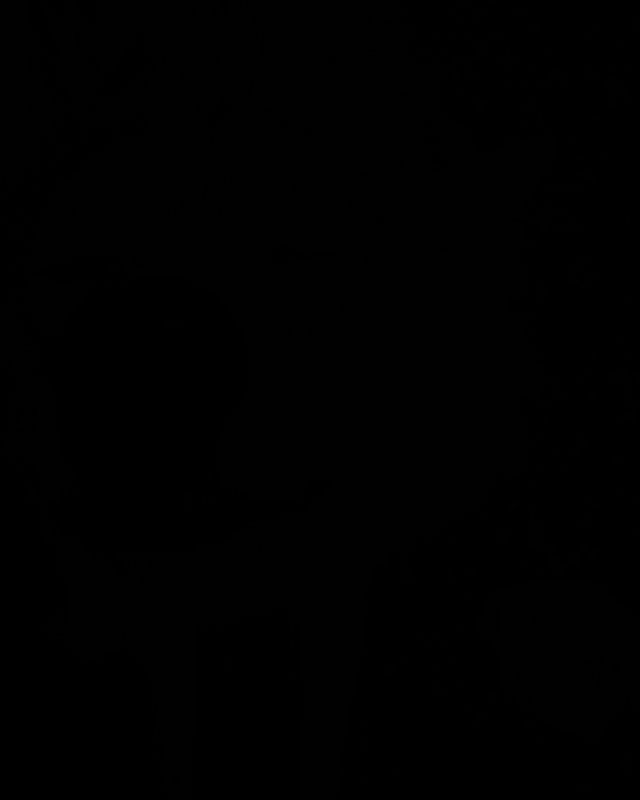

In [18]:
# Binarization
d_gray1 = cuda.to_device(gray_image1)
d_binary = cuda.to_device(binary_image)
binarize_image_gpu[blocks_per_grid, threads_per_block](d_gray1, d_binary, threshold)
d_binary.copy_to_host(binary_image)

(-0.5, 639.5, 799.5, -0.5)

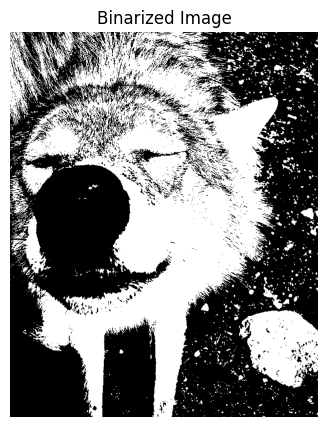

In [19]:
# Display results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(binary_image, cmap='gray')
plt.title('Binarized Image')
plt.axis('off')

array([[208, 205, 255, ..., 174, 178, 178],
       [184, 249, 255, ..., 183, 178, 181],
       [171, 211, 205, ..., 189, 181, 183],
       ...,
       [ 61,  52,  54, ..., 114, 129, 105],
       [ 72,  49,  39, ..., 106, 100,  72],
       [ 70,  48,  37, ...,  91,  84,  76]], dtype=uint8)
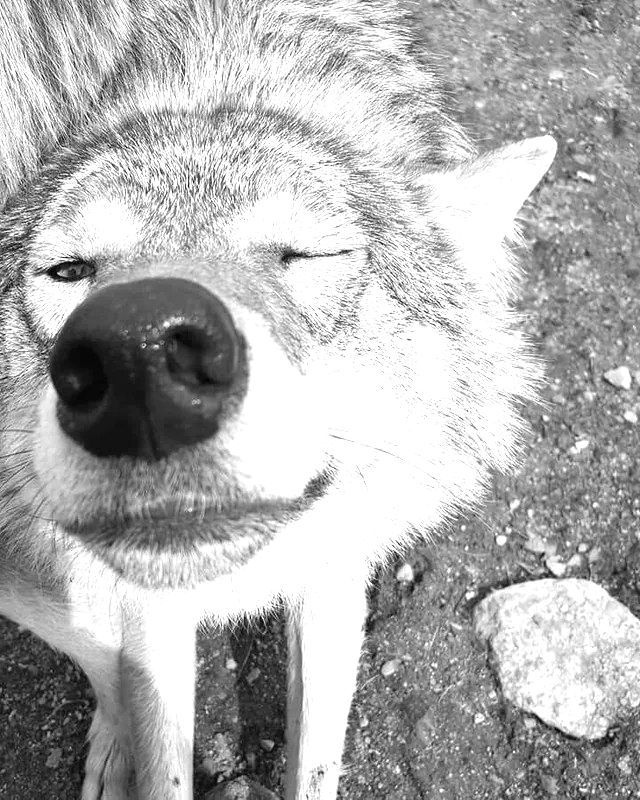

In [20]:
# Brightness Adjustment
d_bright = cuda.to_device(gray_image1)
d_bright_output = cuda.to_device(bright_image)
adjust_brightness_gpu[blocks_per_grid, threads_per_block](d_bright, d_bright_output, brightness_factor)
d_bright_output.copy_to_host(bright_image)

(-0.5, 639.5, 799.5, -0.5)

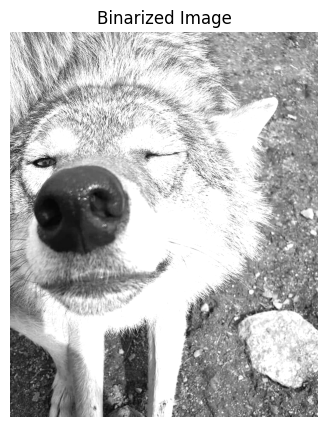

In [22]:
# Display results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(bright_image, cmap='gray')
plt.title('Binarized Image')
plt.axis('off')

array([[ 98,  99, 132, ...,  61,  66,  69],
       [ 90, 113, 120, ...,  77,  74,  72],
       [ 87, 101, 100, ...,  87,  81,  76],
       ...,
       [ 59,  49,  44, ...,  89,  92,  78],
       [ 68,  62,  59, ...,  77,  75,  65],
       [122, 115, 110, ..., 125, 124, 123]], dtype=uint8)
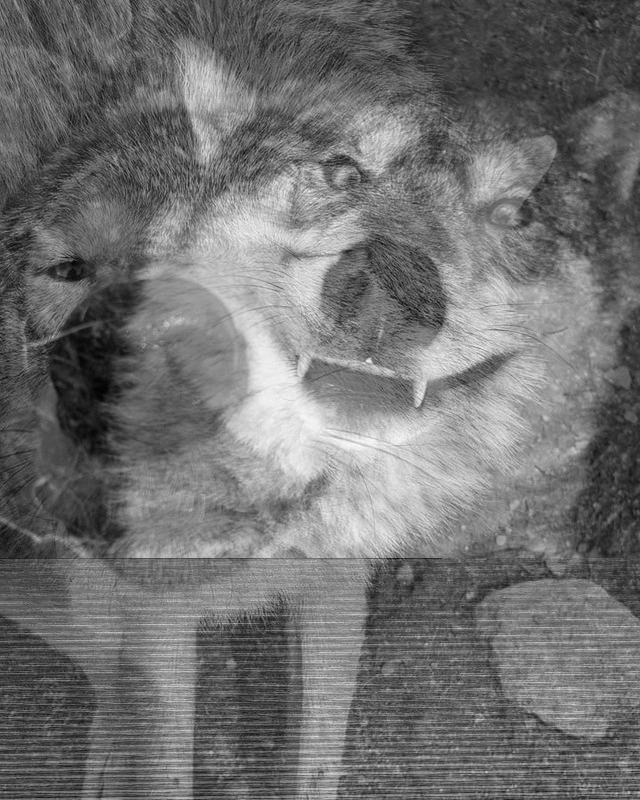

In [23]:
# Blending
d_gray2 = cuda.to_device(gray_image2)
d_blended = cuda.to_device(blended_image)
blend_images_gpu[blocks_per_grid, threads_per_block](d_gray1, d_gray2, d_blended, alpha)
d_blended.copy_to_host(blended_image)

(-0.5, 639.5, 799.5, -0.5)

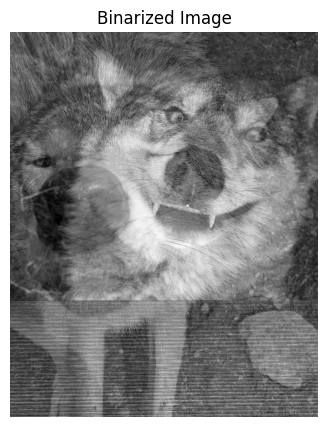

In [24]:
# Display results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(blended_image, cmap='gray')
plt.title('Binarized Image')
plt.axis('off')